# Aim

Get good and fast PSF fitting working, with the current models, in Python 3.8+. This could be using Theano, tf2+, or pytorch, and probably won't be using scipy.

1. (in the `oldeleanor` env) run code from master to show the baseline of fitting works
2. (in the `eleanorupgrade` env) set up frame-by-frame fitting in a new language, for sim data
3. the same as above for real data
4. set up all-at-once fitting using different weights for fluxes, and deviation-from-aperture regularization for coherence
5. the same as above for real data

In [1]:
import eleanor
import numpy as np
import lightkurve as lk
from matplotlib import pyplot as plt
import tqdm
import scipy.optimize as sopt
%load_ext autoreload
%autoreload 2

In [92]:
# first, step 1: surgically extract code from afeinstein20/eleanor/master that still operates with my new API
star = eleanor.Source(tic=120362128, sector=14, tc=True)
star.premade = False
sc = lk.search_targetpixelfile(target='tic120362128', sector=14).download()
sq = sc.quality < 5000
start = 2500
end = 3400
time = sc.time[sq][start:end].value
tpfs = sc.flux[sq][start:end].value
errs = sc.flux_err[sq][start:end].value
bkgs = sc.flux_bkg[sq,0,0][start:end].value
bkg0 = np.mean(bkgs)
data = eleanor.TargetData(
    star, 
    height=11, 
    width=11, 
    do_pca=True, 
    do_psf=False,
)

In [99]:
data.psf_lightcurve(data_arr=tpfs, err_arr=errs, bkg_arr=bkgs, verbose=True, nstars=3, xc=[4.9, 4.5, 4.7], yc=[3.0, 4.4, 7.0], ignore_pixels=1)

100%|██████████| 900/900 [02:38<00:00,  5.66it/s]


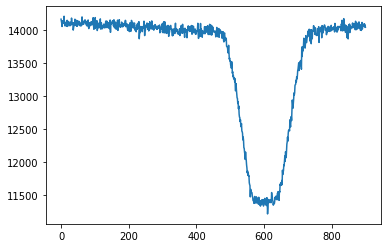

In [100]:
plt.plot(data.psf_flux[:,0])

In [5]:
data.psf_params

AttributeError: 'TargetData' object has no attribute 'psf_params'

In [55]:
xc = [4.9, 4.5, 4.7] 
yc = [3.0, 4.4, 7.0]
model = eleanor.models.Gaussian(
    shape=tpfs.shape[1:],
    col_ref = 0,
    row_ref = 0,
    xc = xc,
    yc = yc,
    fit_idx = 0,
    bkg0 = np.max(bkgs[0])
)
nstars = len(xc)
fout = np.zeros((len(tpfs), 3))
lout = np.zeros(len(tpfs))
pars0 = model.get_default_par(tpfs[0])

tpfs = np.array(tpfs, dtype=np.float32)
errs = np.array(errs, dtype=np.float32)

import torch

def loss_fn(params, i):
    fluxes = params[:nstars]
    xshift, yshift, bkg = params[nstars:nstars+3]
    optpars = params[nstars+3:]
    mean_val = model.mean(fluxes, xshift, yshift, bkg, optpars)
    return torch.sum((mean_val - tpfs[i]) ** 2 / errs[i])

loss_fn(pars0, 0)

tensor([[ 1.5490e+02,  1.6833e+02,  1.5971e+02,  1.5201e+02,  1.3514e+02,
          1.0778e+02,  1.1284e+02,  1.7014e+02,  1.8299e+02,  1.8296e+02,
          1.7386e+02],
        [ 1.2558e+02,  1.0203e+02,  6.6028e+01,  1.2792e+01, -3.1323e+02,
         -3.2346e+02,  4.6149e+00,  1.6407e+02,  1.8000e+02,  1.8294e+02,
          1.7313e+02],
        [ 7.6876e+01, -1.7745e+01, -2.8933e+02, -1.2495e+03, -3.5953e+03,
         -1.1226e+03,  2.4830e+02,  1.7044e+02,  1.7087e+02,  1.5516e+02,
          6.5559e+01],
        [ 1.4099e+01, -1.8172e+02, -9.9418e+02, -4.0841e+03, -8.0877e+03,
         -9.5028e+02,  1.0412e+03,  1.6412e+02,  1.4859e+02,  1.0008e+02,
         -6.0177e+01],
        [-6.5785e+01, -3.8529e+02, -1.8417e+03, -5.5132e+03, -1.1504e+04,
         -4.2573e+03,  4.7969e+02,  9.7076e+01,  1.3586e+02,  1.5082e+02,
          7.7316e+01],
        [ 1.5916e+00, -1.2543e+02, -8.8355e+02, -2.6216e+03, -3.1565e+03,
         -1.7696e+03, -2.9760e+02,  4.8956e+01,  1.4446e+02,  1.7083e+0

tensor(40513674.4687, dtype=torch.float64)

In [60]:
def loss_and_grad_fn(params, i):
    fluxes = params[:nstars]
    xshift, yshift, bkg = params[nstars:nstars+3]
    optpars = params[nstars+3:]
    mean_val = model.mean(fluxes, xshift, yshift, bkg, optpars)
    loss = torch.sum((mean_val - torch.tensor(tpfs[i])) ** 2 / torch.tensor(errs[i]))
    gradient = tgrad(loss, params)
    return loss, gradient

In [62]:
%timeit loss_and_grad_fn(tpars0, 0)

2.67 ms ± 239 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [56]:
tpars0 = torch.tensor(pars0, requires_grad=True)
tgrad(loss_fn(tpars0, 0), tpars0)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [85]:
loss_and_grad_fn(pars0, 0)

(array(40513674.46872798),
 array([-4.92878896e+02, -9.05588895e+02, -4.97592376e+02,  2.26847964e+07,
         7.68668909e+06, -9.01655750e+03, -2.73713533e+06,  1.90166348e+06,
         2.25330535e+05]))

In [86]:
res = sopt.minimize(loss_and_grad_fn, pars0, 0, jac=True, method='TNC', tol=1e-2)

In [87]:
res

     fun: array(2564496.65352548)
     jac: array([-1.04629741e-01, -6.68758784e-02,  2.91729359e-02, -1.31428836e+03,
        1.19985109e+04,  2.54292248e+00, -6.21492178e+03,  2.23892132e+03,
        2.19750982e+03])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 39
     nit: 8
  status: 2
 success: True
       x: array([ 1.41703118e+04,  6.48577457e+04,  4.08965473e+04, -3.71941042e-01,
       -5.89636796e-01,  6.11388556e+01,  7.11063500e-01, -1.08986874e-01,
        8.00197830e-01])

In [21]:
sopt.minimize(loss_and_grad, res.x, 1, jac=True, method='TNC', tol=1e-2)

     fun: DeviceArray(2585573.5, dtype=float32)
     jac: array([-2.31948423e+00, -1.05771911e+00, -4.02379704e+00, -1.22112062e+05,
        1.38084188e+05, -1.97105420e+03,  1.20065875e+05, -7.72302500e+04,
        3.45133125e+04], dtype=float32)
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 33
     nit: 6
  status: 2
 success: True
       x: array([ 1.44533330e+04,  6.50601928e+04,  4.09625208e+04, -3.85942024e-01,
       -5.74232261e-01,  3.87870895e+01,  7.05756095e-01, -1.09814346e-01,
        7.98810856e-01])

In [19]:
%timeit grad_fn(pars0, 1)

178 ms ± 66.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%timeit loss_fn(pars0, 1)

6.92 ms ± 1.75 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [90]:
def loss_and_grad_fn(params, i):
    params = torch.tensor(params, requires_grad=True)
    fluxes = params[:nstars]
    xshift, yshift, bkg = params[nstars:nstars+3]
    optpars = params[nstars+3:]
    mean_val = model.mean(fluxes, xshift, yshift, bkg, optpars)
    loss = torch.sum((mean_val - torch.tensor(tpfs[i])) ** 2 / torch.tensor(errs[i]))
    gradient = tgrad(loss, params)
    return loss.detach().numpy(), gradient[0].detach().numpy()
    
pars = pars0
for i in tqdm.trange(900):
    res = sopt.minimize(loss_and_grad_fn, pars, i, jac=True, method='TNC', tol=1e-4)
    pars = res.x

100%|██████████| 900/900 [01:58<00:00,  7.57it/s]


In [91]:
res

     fun: array(2552975.27989376)
     jac: array([ 2.31716281e-02,  5.72210948e-03, -8.15121986e-03, -6.64077238e+02,
        1.08099661e+03, -1.35094916e+01,  2.86559617e+02,  2.62133548e+02,
        3.10887321e+02])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 15
     nit: 4
  status: 2
 success: True
       x: array([ 1.40474152e+04,  6.49220817e+04,  4.08551444e+04, -3.69057875e-01,
       -5.87534290e-01,  6.18583201e+01,  7.09819184e-01, -1.08128943e-01,
        7.98739481e-01])